# Making a mock observation from the EAGLE simulations

This script is an example script to lay out the individual steps of making mock observations.

The steps are as follows:

1. Load the EAGLE simulated data.  Specify the distance at which we want to observe the cosmic web i.e. redshift of central wavelength of filter and the resolution that the data should be binned to.  The minimum resolution at 50Mpc away is:
2. Cut out a chunk of the simulated data that corresponds to the Dragonfly FOV.  (switched with step 3 because takes too long for the whole simulation)
3. Add the noise to the simulated data to mimic observational noises (includes sky background noise, read out noise, dark current noise, and shot noise).  This depends on the exposure time of the mock observation.
4. Plot the data to check and see what it looks like.

Ta da!

In [9]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

import os
import get_halpha_SB

%matplotlib inline

%run 'load_data.ipynb'
%run 'add_noise.ipynb'
%run 'extract_FOV.ipynb'

### Step 1:  Load the data (load_data.ipynb)
Let's say we want to observe at 100 Mpc away, with a resolution of 100 arcsec.  Our filter width is 3nm which corresponds to about 20 Mpc in radial distance (so we specify a slice width of 20).

In [21]:
distance = '50Mpc'; resolution = 14.; slicewidth = 20; machine='coho'
data_tuple = loaddata(machine=machine,resolution=resolution,distance=distance,slicewidth=slicewidth)

Loading data of slicewidth 20 (after rounding), number of slices is 4
data_50Mpc_14arcsec_20slwd.npz exists, loading now...


In [28]:
total_fname = 'data_50Mpc_14arcsec_20slwd.npz'
sl = [slice(None,None,None), slice(None,None,None)]
data = (np.load(total_fname)['arr_0'])[sl]

In [46]:
data_tuple = (data,32000,1)

In [47]:
data_tuple

(array([[-13.55241013, -13.55892658, -13.5649395 , ..., -13.53071022,
         -13.53818321, -13.54545975],
        [-13.55206394, -13.55818176, -13.56377792, ..., -13.53147316,
         -13.53858566, -13.54549503],
        [-13.552248  , -13.55794525, -13.56310844, ..., -13.53287697,
         -13.53958988, -13.54609299],
        ..., 
        [-13.55694866, -13.56449413, -13.57161903, ..., -13.53250217,
         -13.54086399, -13.54904366],
        [-13.55484104, -13.56207275, -13.56885147, ..., -13.5312233 ,
         -13.53931808, -13.547225  ],
        [-13.55332947, -13.5602169 , -13.56662464, ..., -13.5306263 ,
         -13.53842449, -13.546031  ]], dtype=float32), 32000, 1)

In [45]:
np.savez(total_fname,data)

### Seems to by a python issue that cannot save large numpy object arrays, cPickle breaks or something

### Step 2: Extract the Dragonfly FOV (extract_FOV.ipynb)

In [38]:
resolution = 14.; distance = '50Mpc'
data_FOV_50Mpc, xystarts_50, size_50 = extractFOV(data_tuple,resolution,distance)

distance = '46Mpc'  # ('92Mpc',) actual distance that corresponds to 14" per pixel in the simulation 
data_FOV_46Mpc, xystarts_46, size_46 = extractFOV(data_tuple,resolution,distance)

data_FOV_50Mpc.shape
data_FOV_46Mpc.shape

(771, 515)

The type of size is <type 'list'>
The type of size is <type 'list'>


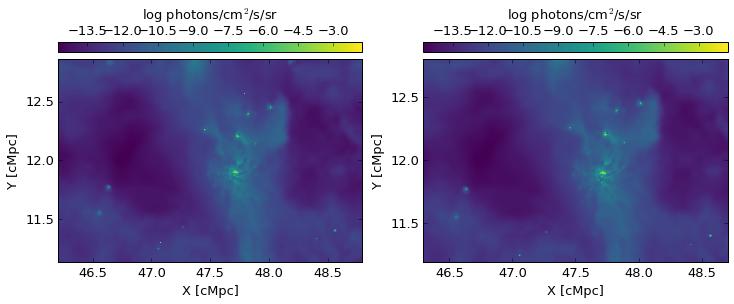

In [39]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 12))
get_halpha_SB.makemap(data_FOV_50Mpc,size_50,ax1,xystarts = xystarts_50)
get_halpha_SB.makemap(data_FOV_46Mpc,size_46,ax2,xystarts = xystarts_46)

In [17]:
#resolution = 100.; distance = '100Mpc';  slicewidth = 20; machine='coho'
#data_tuple = loaddata(machine=machine,resolution=resolution,distance=distance,slicewidth=slicewidth)

Loading data of slicewidth 20 (after rounding), number of slices is 4
data_100Mpc_100arcsec_20slwd.npz exists, loading now...


### Step 3: Add noise to the data (add_noise.ipynb)
Let's say that we want to observe for 1000 hours.

In [41]:
exptime = 1000.*60.*60.
debugging = True; R_squared = None; CMOS = False
noiseadded_signal_50,B_sky_array_50,R_array_50 = addnoise(data_FOV_50Mpc,resolution,exptime=exptime,debugging=True)#,expnum=1)
# default for addnoise: oldcam == old QE and old R

******* Adding noise to the input data to simulate a mock observation by the 48.0 lens Dragonfly Telescope *******
DEBUGGING: the binpix_size (resolution) is 14.0
DEBUGGING: the pixel size (inherent) is 2.8
VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
DEBUGGING: R is : 10.0
DEBUGGING: the number of pixels per bin is 25.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the total object signal [electrons] detected ranges from: 9.21508e-14 to 0.898383
The width of the filter that the data was taken with is 3.0 nm. 
DEBUGGING: Sky background in filter width of 3.0 nm is calculated already: 1.473626.
Adding sky background noise and shot noise...
DEBUGGING: the background in the bandwidth is: 1.473626 photon/s/arcsec^2/m^2
DEBUGGING: the background signal, B_sky, is: 3.6338474778 electron/s/pixel
DEBUGGING: the mean total background signal, B_sky_total [electrons], is: 327046273.002
DEBUGGING: the total background noisy signal [electrons] ranges from: -9035

KeyboardInterrupt: 

### Step 4: Save the data

In [ ]:
print np.mean(B_sky_array)
print np.mean(R_array)

if CMOS:
    cams = 'newcam'
else:
    cams = 'oldcam'

if R_squared:
    cams = cams+'_Rsquared%s'%R_squared

fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth)
R_fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_RARRAY.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth)
B_sky_fname = 'noisy_fov_%shr_%s_%sdist_%sarcsec_%sslwd_BSKYARRAY.npz' \
            % (round(exptime/3600.),cams,distance,resolution,slicewidth)

#np.savez(noiseadded_signal)


### Step 5: Plot the data

3362.89284353
-214.220413144
(105, 71)
[[-10097.17277528  -6022.35446411   8076.70416505 ...,  -4785.48341214
   -7989.691547    -7953.31815763]
 [ -5887.82944365 -20023.99166745  10958.08654567 ..., -15536.63635573
   -9431.50371072   5407.93523193]
 [ 18403.37194288 -16457.36441655 -25235.6184102  ...,   1868.03280851
    2210.9965035   -4635.24159214]
 ..., 
 [ -7747.96693491   -562.98692847  12793.39885673 ...,   6413.12034369
   14908.52195561   -793.06777223]
 [-12926.96253931  -8504.27218069   -358.43148638 ..., -13458.05928956
   -2708.01822965   -709.9073958 ]
 [-20415.20474249  -8145.13034087   9717.14160579 ...,  14381.1394182
    1717.50735581   9181.80061487]]


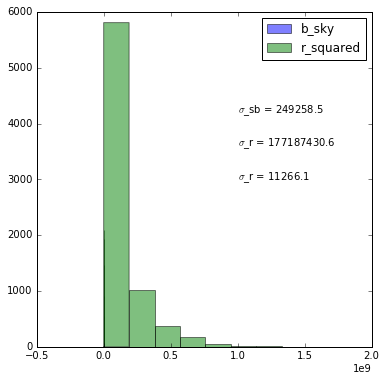

In [41]:
def plthist(ax3,B_sky,R_squared,R,title='',label1='',label2='',label3=''):
    ax3.hist(np.ravel(B_sky),edgecolor='black', alpha = 0.5,label=label1)
    ax3.hist(np.ravel(R_squared),edgecolor='black', alpha = 0.5,label=label2)
    #ax3.hist(np.ravel(R),edgecolor='black', alpha = 0.5, label=label3)
    ax3.text(0.6,0.7,r'$\sigma$_sb = %.1f'%(np.std(B_sky)),transform=ax3.transAxes)
    ax3.text(0.6,0.6,r'$\sigma$_r = %.1f'%(np.std(R_squared)),transform=ax3.transAxes)
    ax3.text(0.6,0.5,r'$\sigma$_r = %.1f'%(np.std(R)),transform=ax3.transAxes)
    #ax3.set_ylim(0,8500)
    #ax3.set_xlim(-1500,2000)
    ax3.set_title(title)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
plthist(ax1,B_sky_array,R_array**2,R_array,label1='b_sky',label2='r_squared',label3='r')
ax1.legend()
print B_sky_array.shape
print R_array

R_squared is huge!  I wonder if maybe before I was comparing just the R value to the sky background value.  I'm not sure though.  This also might be the difference of adding up read out noise over the 1000 exposures.  I will try it again with only one exposure now

### Step 3 & 4 again, but with different params

In [45]:
noiseadded_signal_2,B_sky_array_2,R_array_2 = addnoise(data_FOV,resolution,exptime=exptime,debugging=True,expnum=1)


VERBOSE: Using old cameras... (QE = 0.48, R = 10.)
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1276.0
DEBUGGING: raise the data by 10** since was logged data before...
DEBUGGING: the shape of the input data is:
(105, 71)
DEBUGGING: the total object signal [electrons] detected ranges from: 2.67696e-12 to 274.123
DEBUGGING: the shape of the detsignal is:
(105, 71)
Adding sky background noise and shot noise.
DEBUGGING: the background in the bandwidth is: 0.560633
DEBUGGING: the background signal, B_sky [ph/s (in a pixel)], is: 13.824775167
DEBUGGING: the shape of B_sky_array is: 
(105, 71)
DEBUGGING: the mean total background signal, B_sky_total [electrons], is: 63505487207.0
DEBUGGING: the total background noisy signal [electrons] ranges from: -898917.893557 to 913369.297058
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
VERBOSE:  At line 0 out of 105
VERBOSE:  At line 1 out of 105
VERBOSE:  At line 2 out of 105
VERBOSE:  At line 3 ou

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


VERBOSE:  At line 43 out of 105
VERBOSE:  At line 44 out of 105
VERBOSE:  At line 45 out of 105
VERBOSE:  At line 46 out of 105
VERBOSE:  At line 47 out of 105
VERBOSE:  At line 48 out of 105
VERBOSE:  At line 49 out of 105
VERBOSE:  At line 50 out of 105
VERBOSE:  At line 51 out of 105
VERBOSE:  At line 52 out of 105
VERBOSE:  At line 53 out of 105
VERBOSE:  At line 54 out of 105
VERBOSE:  At line 55 out of 105
VERBOSE:  At line 56 out of 105
VERBOSE:  At line 57 out of 105
VERBOSE:  At line 58 out of 105
VERBOSE:  At line 59 out of 105
VERBOSE:  At line 60 out of 105
VERBOSE:  At line 61 out of 105
VERBOSE:  At line 62 out of 105
VERBOSE:  At line 63 out of 105
VERBOSE:  At line 64 out of 105
VERBOSE:  At line 65 out of 105
VERBOSE:  At line 66 out of 105
VERBOSE:  At line 67 out of 105
VERBOSE:  At line 68 out of 105
VERBOSE:  At line 69 out of 105
VERBOSE:  At line 70 out of 105
VERBOSE:  At line 71 out of 105
VERBOSE:  At line 72 out of 105
VERBOSE:  At line 73 out of 105
VERBOSE:

4461.60171159
-5.4198151991


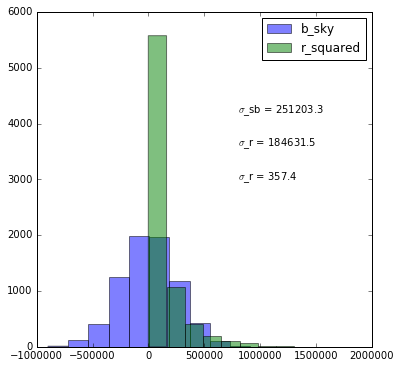

In [46]:
print np.mean(B_sky_array_2)
print np.mean(R_array_2)
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
plthist(ax1,B_sky_array_2,R_array_2**2,R_array_2,label1='b_sky',label2='r_squared',label3='r')
ax1.legend()

It seems that that is the difference.

But now that I stop to think about it, I should be comparing the R value not the R_squared values to the array, since I am not adding in quadrature, I'm just straight up adding the noise by drawing from their distributions.

Shoot ahaha.

I have to go back and check on my add_noise function - it was adding the R_squared values, but should actually just add the R values.  



### Step 5: Plot the data

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
get_halpha_SB.makemap(noiseadded_signal,size,ax1,xystarts = xystarts)